**Task 2 : Decision Trees for Human Activity Recognition [3 marks]**

**Question 1**: Use Sklearn Library to train Decision Tress. [1.5 marks]


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
import tsfel

train_paths = {
    'Laying' : r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\Combined\Train\LAYING\Subject_1.csv',
    'Sitting' : r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\Combined\Train\SITTING\Subject_3.csv',
    'Standing' : r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\Combined\Train\STANDING\Subject_5.csv',
    'Walking' : r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\Combined\Train\Walking\Subject_6.csv',
    'Walking_Downstairs' : r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\Combined\Train\WALKING_DOWNSTAIRS\Subject_7.csv',
    'walking_Upstairs' : r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\Combined\Train\WALKING_UPSTAIRS\Subject_8.csv'
}

test_paths = {
    'Laying' : r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\Combined\Test\LAYING\Subject_2.csv',
    'Sitting' : r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\Combined\Test\SITTING\Subject_4.csv',
    'Standing' : r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\Combined\Test\STANDING\Subject_9.csv',
    'Walking' : r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\Combined\Test\Walking\Subject_10.csv',
    'Walking_Downstairs' : r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\Combined\Test\WALKING_DOWNSTAIRS\Subject_12.csv',
    'walking_Upstairs' : r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\Combined\Test\WALKING_UPSTAIRS\Subject_13.csv'
}


def make_data(path):
    final_data = []
    labels = []
    mapping = {label: idx for idx, label in enumerate(path.keys())}

    for activity,path in path.items():
        data = pd.read_csv(path, nrows=500)
        data["label"] = mapping[activity]
        labels.append(data['label'])
        data['acc'] = data['accx']**2 + data['accy']**2 + data['accz']**2
        final_data.append(data[["accx",'accy','accz','acc','label']])

    return final_data,labels



def data_analysis(train_paths,test_paths):

    activity_mapping = {
    0: 'LAYING',
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING'
    }

    train_data, train_labels = make_data(train_paths)

    X_train = pd.concat(train_data, ignore_index=True)
    y_train = np.concatenate(train_labels)

    X_train, y_train = shuffle(X_train, y_train, random_state=420)

    train_combined = X_train.copy()
    train_combined["activity"] = y_train
    train_combined['activity'] = train_combined['activity'].map(activity_mapping)

    X_train_final = train_combined[["accx",'accy','accz','acc']]  
    y_train_final = train_combined["activity"]

    test_data, test_labels = make_data(test_paths)

    X_test = pd.concat(test_data, ignore_index=True)
    y_test = np.concatenate(test_labels)

    test_combined = X_test.copy()
    test_combined["activity"] = y_test
    test_combined['activity'] = test_combined['activity'].map(activity_mapping)

    X_test_final = test_combined[["accx",'accy','accz','acc']]  
    y_test_final = test_combined["activity"]

    return (X_train_final,y_train_final,X_test_final,y_test_final)


def tsfel_data(X_train_final,X_test_final,y_train_final,y_test_final):

    cfg_file = tsfel.get_features_by_domain("statistical")

    selected_features = {
    'statistical': {
        'root_mean_square': cfg_file['statistical']['Root mean square'],
        'Std': cfg_file['statistical']['Standard deviation'],
        'Mean': cfg_file['statistical']['Mean'],
        'ECDF': cfg_file['statistical']['ECDF']
        }
    }

    X_tsfel_train = tsfel.time_series_features_extractor(selected_features, X_train_final,window_size=1, verbose=0)
    X_tsfel_test = tsfel.time_series_features_extractor(selected_features, X_test_final, window_size=1,verbose=0)

    pca = PCA(n_components = 2)
    X_tsfel_train_pca = pca.fit_transform(X_tsfel_train)
    X_tsfel_test_pca = pca.transform(X_tsfel_test)

    pca_train_df = pd.DataFrame(data=X_tsfel_train_pca, columns=["PCA_1", "PCA_2"])
    pca_test_df = pd.DataFrame(data=X_tsfel_test_pca, columns=["PCA_1", "PCA_2"])

    pca_train_df["Label"] = y_train_final.reset_index(drop=True)
    pca_test_df["Label"] = y_test_final.reset_index(drop=True)

    pca_train_df, pca_test_df = shuffle(pca_train_df, pca_test_df, random_state=420)
    pca_train_df = pca_train_df.drop("Label",axis ="columns")
    pca_test_df = pca_test_df.drop("Label",axis = "columns")

    return(pca_train_df, pca_test_df)

def Model(X_train_final, y_train_final, X_test_final, y_test_final):

    model = DecisionTreeClassifier()
    model.fit(X_train_final, y_train_final)

    y_pred = model.predict(X_test_final)

    print("Test Accuracy:", accuracy_score(y_test_final, y_pred))
    print("Test Classification Report:")
    print(classification_report(y_test_final, y_pred))

    conf_matrix = confusion_matrix(y_test_final, y_pred)
    sns.heatmap(conf_matrix,annot = True)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

X_train_final, y_train_final, X_test_final, y_test_final = data_analysis(train_paths, test_paths)
pca_train_df, pca_test_df = tsfel_data(X_train_final, X_test_final,y_train_final,y_test_final)

C:\Users\Vansh\AppData\Local\Temp\ipykernel_14448\4277860546.py:100: UserWarning: Using default sampling frequency set in configuration file.
  X_tsfel_train = tsfel.time_series_features_extractor(selected_features, X_train_final,window_size=1, verbose=0)


C:\Users\Vansh\AppData\Local\Temp\ipykernel_14448\4277860546.py:101: UserWarning: Using default sampling frequency set in configuration file.
  X_tsfel_test = tsfel.time_series_features_extractor(selected_features, X_test_final, window_size=1,verbose=0)


**1.1** - Train a decision tree model using the raw accelerometer data. Report the accuracy, precision, recall and confusion matrix of the model.

Metrics of RAW Accelerometer Data
Test Accuracy: 0.5733333333333334
Test Classification Report:
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       500
           SITTING       0.30      0.29      0.29       500
          STANDING       0.36      0.38      0.37       500
           WALKING       0.91      0.27      0.42       500
WALKING_DOWNSTAIRS       0.53      0.52      0.53       500
  WALKING_UPSTAIRS       0.56      0.98      0.72       500

          accuracy                           0.57      3000
         macro avg       0.61      0.57      0.55      3000
      weighted avg       0.61      0.57      0.55      3000



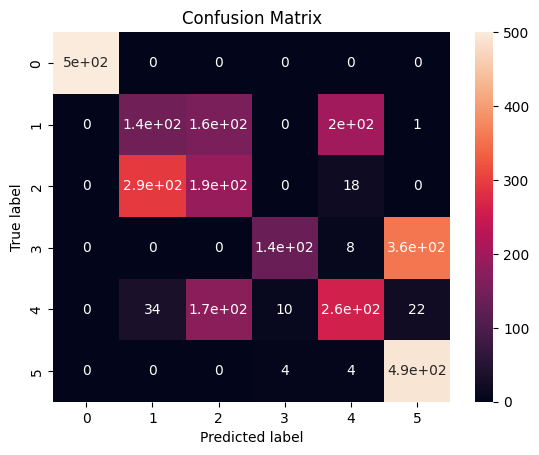

In [3]:
print("Metrics of RAW Accelerometer Data")
Model(X_train_final,y_train_final,X_test_final,y_test_final)

**1.2** - Train a decision tree model using the features obtained by TSFEL. Report the accuracy, precision, recall and confusion matrix of the model.

Metrics of TSFEL Data
Test Accuracy: 0.16466666666666666
Test Classification Report:
                    precision    recall  f1-score   support

            LAYING       0.16      0.10      0.13       500
           SITTING       0.19      0.20      0.19       500
          STANDING       0.17      0.28      0.21       500
           WALKING       0.12      0.07      0.09       500
WALKING_DOWNSTAIRS       0.17      0.24      0.20       500
  WALKING_UPSTAIRS       0.16      0.10      0.12       500

          accuracy                           0.16      3000
         macro avg       0.16      0.16      0.16      3000
      weighted avg       0.16      0.16      0.16      3000



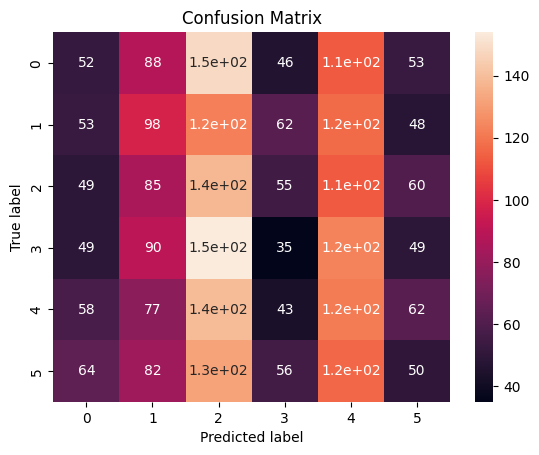

In [4]:
print("Metrics of TSFEL Data")
Model(pca_train_df,y_train_final,pca_test_df,y_test_final)

**1.3** - Train a decision tree model using the features provided in the dataset. Report the accuracy, precision, recall and confusion matrix of the model.

Metrics of Provided Features Data
Test Accuracy: 0.5934848998982015
Test Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.67      0.65       496
           2       0.64      0.59      0.61       471
           3       0.66      0.59      0.62       420
           4       0.55      0.53      0.54       491
           5       0.53      0.58      0.56       532
           6       0.58      0.60      0.59       537

    accuracy                           0.59      2947
   macro avg       0.60      0.59      0.60      2947
weighted avg       0.60      0.59      0.59      2947



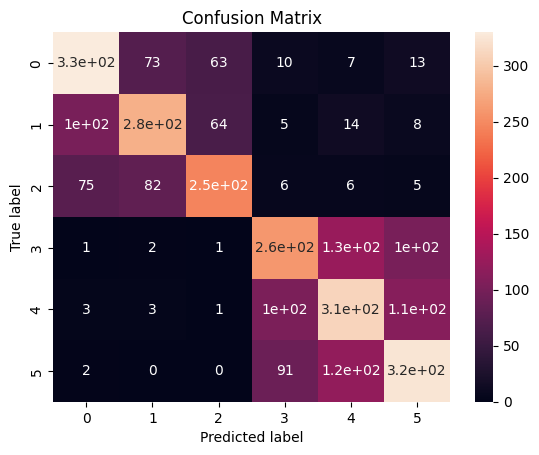

In [5]:
body_acc_x_train = r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\UCI HAR Dataset\train\Inertial Signals\body_acc_x_train.txt'
body_acc_y_train = r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\UCI HAR Dataset\train\Inertial Signals\body_acc_y_train.txt'
body_acc_z_train = r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\UCI HAR Dataset\train\Inertial Signals\body_acc_z_train.txt'

body_gyro_x_train = r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\UCI HAR Dataset\train\Inertial Signals\body_gyro_x_train.txt'
body_gyro_y_train = r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\UCI HAR Dataset\train\Inertial Signals\body_gyro_y_train.txt'
body_gyro_z_train = r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\UCI HAR Dataset\train\Inertial Signals\body_gyro_z_train.txt'

y_train_path = r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\UCI HAR Dataset\train\y_train.txt'

def load_provided_features(acc_x_path, acc_y_path, acc_z_path, gyro_x_path, gyro_y_path, gyro_z_path, y_path):
    acc_x = np.loadtxt(acc_x_path)
    acc_y = np.loadtxt(acc_y_path)
    acc_z = np.loadtxt(acc_z_path)
    gyro_x = np.loadtxt(gyro_x_path)
    gyro_y = np.loadtxt(gyro_y_path)
    gyro_z = np.loadtxt(gyro_z_path)
    y = np.loadtxt(y_path).astype(int)
    X = np.hstack((acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z))

    return X, y

X_train_provided, y_train_provided = load_provided_features(
    body_acc_x_train, body_acc_y_train, body_acc_z_train,
    body_gyro_x_train, body_gyro_y_train, body_gyro_z_train,
    y_train_path
)

body_acc_x_test = r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\UCI HAR Dataset\test\Inertial Signals\body_acc_x_test.txt'
body_acc_y_test = r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\UCI HAR Dataset\test\Inertial Signals\body_acc_y_test.txt'
body_acc_z_test = r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\UCI HAR Dataset\test\Inertial Signals\body_acc_z_test.txt'

body_gyro_x_test = r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\UCI HAR Dataset\test\Inertial Signals\body_gyro_x_test.txt'
body_gyro_y_test = r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\UCI HAR Dataset\test\Inertial Signals\body_gyro_y_test.txt'
body_gyro_z_test = r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\UCI HAR Dataset\test\Inertial Signals\body_gyro_z_test.txt'

y_test_path = r'C:\Users\Vansh\Desktop\Coding\ML\Assignment 1\Task 1\UCI HAR Dataset\test\y_test.txt'

X_test_provided, y_test_provided = load_provided_features(
    body_acc_x_test, body_acc_y_test, body_acc_z_test,
    body_gyro_x_test, body_gyro_y_test, body_gyro_z_test,
    y_test_path
)

def train_model(X_train, y_train, X_test, y_test):
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    print("Test Classification Report:")
    print(classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
print("Metrics of Provided Features Data")
train_model(X_train_provided, y_train_provided, X_test_provided, y_test_provided)

**1.4** - Compare the results of the three models. Which model do you think is better?

**Ans** - 

1. Model Trained on Raw Accelerometer Data: <br>
Accuracy: 0.57 <br>
Precision, Recall, F1-Score (Macro Avg): 0.61, 0.57, 0.55 <br>
Confusion Matrix: Some misclassifications are there, especially between sitting, standing, and walking. <br>

2. Model Trained on TSFEL Extracted Features: <br>
Accuracy: 0.16 <br>
Precision, Recall, F1-Score (Macro Avg): 0.16, 0.16, 0.16 <br>
Confusion Matrix: This model has many misclarifications. Hence a poor model.  <br>

3. Model Trained on Provided Features (Body_acc and Body_gyro):  <br>
Accuracy: 0.59 <br>
Precision, Recall, F1-Score (Macro Avg): 0.60, 0.59, 0.59 <br>
Confusion Matrix: This model performs the best overall, with fewer misclassifications compared to the other models. <br>

**Conclusion:** <br>
The model trained on provided features (Body_acc and Body_gyro) is the best among the three, as it has the highest accuracy (0.59) and balanced precision, recall, and F1-scores. <br>
The model trained on raw accelerometer data is the second-best, performing relatively well but with lower overall metrics compared to the provided features model.<br>
The model trained on TSFEL features performs the worst, with very low accuracy and poor classification performance.<br>

**Thus, the model trained on the provided features is preferable for this task.**

**Question 2** - Train Decision Tree with varying depths (2-8) using all above 3 methods. Plot the accuracy of the model on test data vs the depth of the tree. [1 marks]


C:\Users\Vansh\AppData\Local\Temp\ipykernel_14448\4277860546.py:100: UserWarning: Using default sampling frequency set in configuration file.
  X_tsfel_train = tsfel.time_series_features_extractor(selected_features, X_train_final,window_size=1, verbose=0)


C:\Users\Vansh\AppData\Local\Temp\ipykernel_14448\4277860546.py:101: UserWarning: Using default sampling frequency set in configuration file.
  X_tsfel_test = tsfel.time_series_features_extractor(selected_features, X_test_final, window_size=1,verbose=0)


Accuracy vs Depth for Raw Data


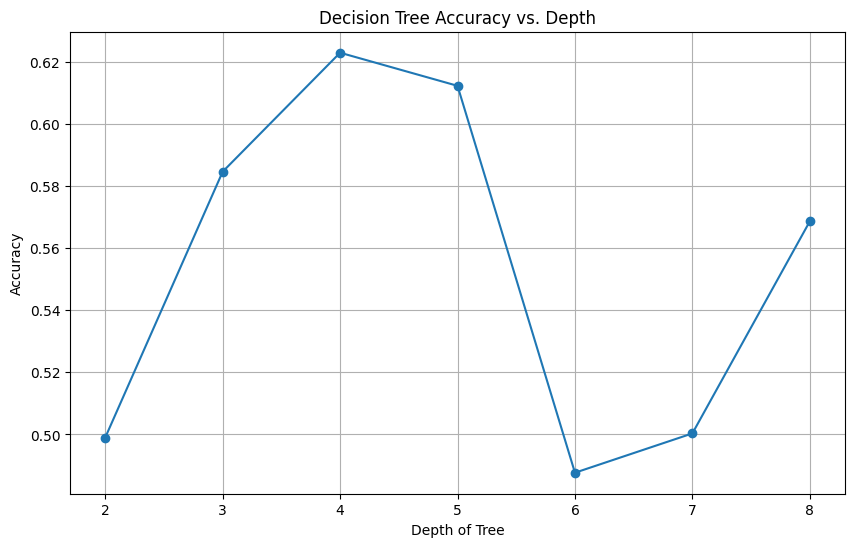

range(2, 9) [0.499, 0.5846666666666667, 0.623, 0.6123333333333333, 0.4876666666666667, 0.5003333333333333, 0.5686666666666667]
Accuracy vs Depth for TSFEL Data


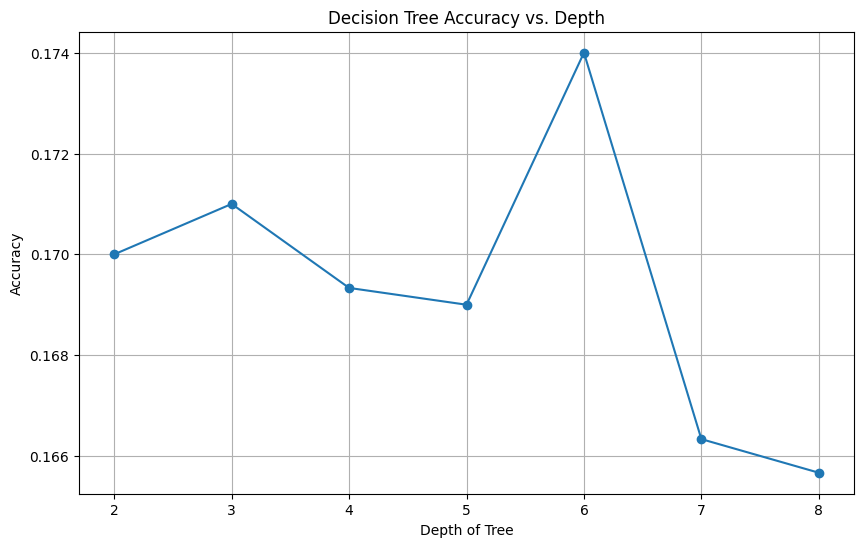

range(2, 9) [0.17, 0.171, 0.16933333333333334, 0.169, 0.174, 0.16633333333333333, 0.16566666666666666]
Accuracy vs Depth for Provided Features Data


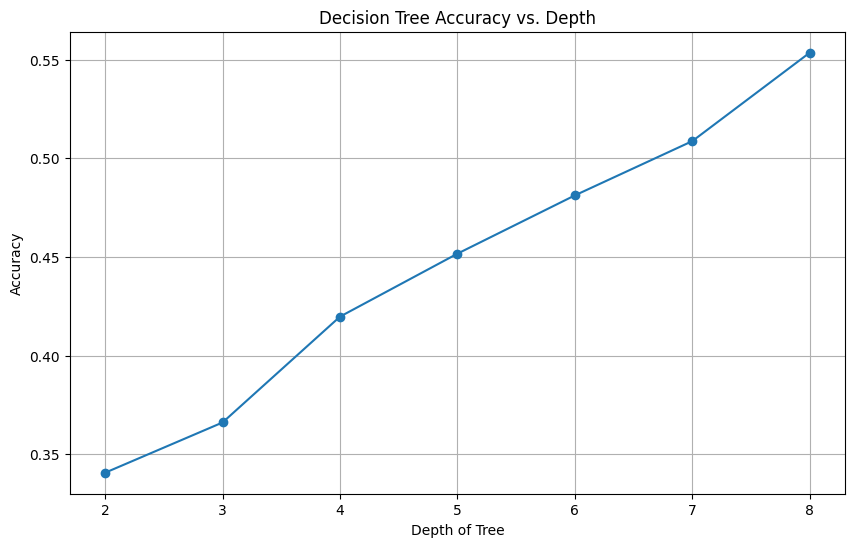

range(2, 9) [0.34068544282321006, 0.3661350525958602, 0.4197488971835765, 0.45164574143196473, 0.4811672887682389, 0.5086528673227011, 0.5534441805225653]


In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def evaluate_tree_depths(X_train, y_train, X_test, y_test, min_depth=2, max_depth=8):
    depths = range(min_depth, max_depth + 1)
    accuracies = []

    for depth in depths:
        model = DecisionTreeClassifier(max_depth=depth)
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

    plt.figure(figsize=(10, 6))
    plt.plot(depths, accuracies, marker='o')
    plt.title('Decision Tree Accuracy vs. Depth')
    plt.xlabel('Depth of Tree')
    plt.ylabel('Accuracy')
    plt.xticks(depths)
    plt.grid(True)
    plt.show()

    print(depths, accuracies)

X_train,y_train,X_test,y_test = data_analysis(train_paths,test_paths)
tsfel_train,tsfel_test = tsfel_data(X_train,X_test,y_train,y_test)

print('Accuracy vs Depth for Raw Data')
evaluate_tree_depths(X_train,y_train,X_test,y_test)
print('Accuracy vs Depth for TSFEL Data')
evaluate_tree_depths(tsfel_train,y_train,tsfel_test,y_test)
print('Accuracy vs Depth for Provided Features Data')
evaluate_tree_depths(X_train_provided, y_train_provided, X_test_provided, y_test_provided)

**Question 3**- Are there any participants/ activitivies where the Model performace is bad? If Yes, Why? [0.5 mark]

**Ans** - 
There are specific activities where the model's performance is bad. 

**1) For Raw Accelerometer Data Confusion Matrix:-** <br>
   Sitting (Activity 2): The precision and recall are both around 0.3, indicating that the model struggles to classify this activity correctly. <br>
   Standing (Activity 3): Similarly, the model has low precision and recall for standing.

   The confusion in sitting and standing activity suggests that they might have similar accelerometer pattern. both are pretty similar activities because in both these situations, the subject is stationary.

**2) For TSFEL Confusion Matrix:-**  
   All activities have low precision and low recall values and hence the entire model performs poorly here. <br>

   The poor performance of TSFEL feature model suggests that these features might not capture necessary information to differentiate between all activities.

**3) For Provided Features Confusion Matrix:-** <br>
   Walking Downstairs (Activity 5): This activity shows poor performance with a relatively low precision (0.54) and recall (0.58).

   This model might not be working properly for Walking_Downstairs because this might be overlapping with similar activities like Walking and Walking_Upstairs. 


